# Fawcett's formula

Consider the (Stratonovich) signature of standard Brownian motion $\mathbb{W}^{<\infty}_{0,T}$ (without time extension for simplicity). We claim that
$$
\mathbb{E} \left[ \mathbb{W}^{<\infty}_{0,T} \right] = \exp_{\otimes} \left( \frac{T}{2} \sum_{i=1}^d e_i \otimes e_i \right).
$$
In this notebook, we are going to verify the formula numerically based on simulations.

# Set up our environment

We will use the package `iisignature` to compute signatures.

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
import iisignature as ii

# Generate paths of the Brownian motion

Write a function to generate sample paths of the Brownian motion, and then generate a sample.

In [3]:
def generate_Brownian_motion(M: int, N: int, d: int, T: float, rng: np.random.Generator) -> np.ndarray:
    """_summary_

    Parameters
    ----------
    M : int
        Number of paths to be generated.
    N : int
        Number of timesteps. We use a uniform grid.
    d : int
        Dimension of the Brownian motion.
    T : float
        Endpoint of the interval.
    rng : np.random.Generator
        RNG object.

    Returns
    -------
    np.ndarray
        An array of shape (M, N+1, d), containing the paths of the Brownian motion.
    """
    dt = T/N
    dW = np.sqrt(dt) * rng.standard_normal((M,N,d))
    return np.cumsum(np.concatenate((np.zeros((M, 1, d)), dW), axis=1), axis=1)

In [4]:
rng = np.random.default_rng()
M = 1000
N = 100
d = 2
T = 2.0

W = generate_Brownian_motion(M, N, d, T, rng)

Plot some trajectories to visually check whether things worked.

Text(0, 0.5, '$W$')

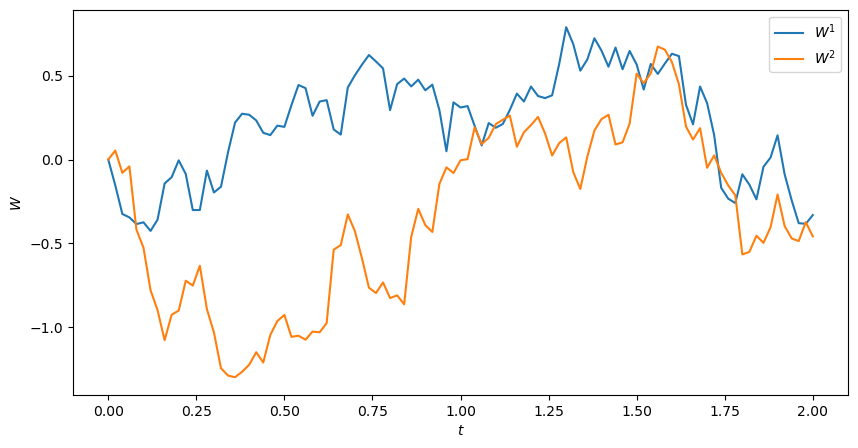

In [5]:
t_grid = np.linspace(0, T, N+1)

fig, ax  = plt.subplots(figsize=(10,5))
ax.plot(t_grid, W[3,:,0], label=r"$W^1$")
ax.plot(t_grid, W[3,:,1], label=r"$W^2$")
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$W$")

# Compute the expected signature

First we compute the signature using `iisignature`, then we take sample means to estimate the expected signature.

In [6]:
K = 4 # degree of the signature
sig_W = ii.sig(W, K)
E_sig_W = np.mean(sig_W, axis=0) # estimated mean
sd_sig_W = np.std(sig_W, axis=0) # estimated standard deviation

Just print the results together with the standard MC error estimate.

In [7]:
for i in range(len(E_sig_W)):
    print(f"E[sig] = {E_sig_W[i]} +- {sd_sig_W[i]/np.sqrt(M)}.")


E[sig] = -0.04503735176099079 +- 0.04389535612595188.
E[sig] = 0.04263067142088736 +- 0.04520253030718768.
E[sig] = 0.9644153262388935 +- 0.04332729061650708.
E[sig] = 0.007006098311297051 +- 0.0431174170313279.
E[sig] = 0.0060622286987680575 +- 0.04529333177920248.
E[sig] = 1.0225430601590089 +- 0.04679994623899461.
E[sig] = -0.10617196249208784 +- 0.05388685439654597.
E[sig] = 0.036943984565493936 +- 0.04112925198511421.
E[sig] = -0.012203467114855353 +- 0.03485582876879912.
E[sig] = -0.07394913476501383 +- 0.044990685592425875.
E[sig] = -0.0300261944874029 +- 0.04596716801633604.
E[sig] = 0.040359291593624114 +- 0.03682151348927627.
E[sig] = 0.014775630232633598 +- 0.044118503097040206.
E[sig] = 0.05140921292950801 +- 0.06236235623768232.
E[sig] = 0.4678918389419552 +- 0.044760733610871586.
E[sig] = 0.061463542797766904 +- 0.0353817153688783.
E[sig] = 0.01784045061612028 +- 0.028301054484409862.
E[sig] = 0.4611985238561977 +- 0.03340358257751745.
E[sig] = -0.0015877390932683866 +- 0

# Code implementing Fawcett's formula

We start with helper code to map indices to multi-indices and conversely. This allows us to properly read the output of `iisignature`.

In [8]:
class Index2Multi:
    # generate all multi-indices in {0, ..., d} up to length n
    @staticmethod
    def _generate_lists_of_length_n_lexicographic(n, d):
        if n == 0:
            return [[]]

        def generate_lexicographic_lists(length, current_list, d):
            if length == 0:
                return [current_list]
            
            lists = []
            for entry in range(1, d+1):  # 0, 1, ..., d
                new_list = current_list + [entry]
                lists.extend(generate_lexicographic_lists(length - 1, new_list, d))
            return lists

        result = generate_lexicographic_lists(n, [], d)
        return result

    @staticmethod
    def _generate_lists_up_to_n_lexicographic(n, d):
        result = []
        for i in range(n+1):
            result += \
                Index2Multi._generate_lists_of_length_n_lexicographic(i, d)
        return result

    # Create a map between A and B and its inverse.
    # Assume that entries of A are hashable but entries of B are lists.
    @staticmethod
    def _create_bidirectional_mapping(A, B):
        # Convert list entries to tuples to make them hashable
        B_hashable = [tuple(b) for b in B]

        mapping_A_to_B = {a: b for a, b in zip(A, B_hashable)}
        mapping_B_to_A = {b: a for a, b in zip(A, B_hashable)}

        def lookup_A_to_B(item):
            return list(mapping_A_to_B.get(item))

        def lookup_B_to_A(item):
            item_tuple = tuple(item)
            return mapping_B_to_A.get(item_tuple)

        return lookup_A_to_B, lookup_B_to_A

    # Now apply this to create maps between indices and multiindices 
    # and conversely.
    @staticmethod
    def _construct_multi_indices(n, d):
        multi_indices = \
            Index2Multi._generate_lists_up_to_n_lexicographic(n, d)
        N = len(multi_indices)
        indices = list(range(N))
        index2multi, multi2index = \
            Index2Multi._create_bidirectional_mapping(indices, multi_indices)
        
        return indices, multi_indices, index2multi, multi2index
    
    # Finally, we initailize the class
    def __init__(self, K: int, d: int):
        self.K = K
        self.d = d
        self.indices, self.multi_indices, self.index2multi, self.multi2index = Index2Multi._construct_multi_indices(K, d)

    # The call method will call index2multi
    def __call__(self, i: int) -> list:
        return self.index2multi(i)

In [11]:
index2multi = Index2Multi(K, d)
print(index2multi.indices)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


Next, we write code to evaluate $\langle w, \mathbb{E}\left[ \mathbb{W}^{<\infty}_{0,T} \right] \rangle$ for words (i.e., multi-indices) $w$.

In [16]:
def check_decomposability(x: list) -> int:
    """
    Checks if a list is composed entirely of adjacent identical pairs.

    The function returns 1 if the list is non-empty, has an even length,
    and every adjacent pair of elements (x[i], x[i+1]) consists of identical values.
    Otherwise, it returns 0.

    Args:
        x: A list of numbers (letters).

    Returns:
        1 if the list consists entirely of adjacent identical pairs, 0 otherwise.
    """
    # An empty list does consist of adjacent identical pairs.
    if not x:
        return 1

    # If the list has an odd number of elements, it cannot be
    # composed entirely of pairs.
    if len(x) % 2 != 0:
        return 0

    # Iterate through the list, taking two elements at a time
    # We use a step of 2 (range(0, len(x), 2)) to check adjacent pairs.
    for i in range(0, len(x), 2):
        # If any adjacent pair is not identical, the condition is not met.
        if x[i] != x[i+1]:
            return 0
    
    # If the loop completes, it means all adjacent pairs were identical.
    return 1

def evaluate_Fawcett(d: int, T: float, w: list) -> float:
    """Evalujate the Fawcett formula.

    Parameters
    ----------
    d : int
        Dimension of the Brownian motion
    T : float
        Terminal time.
    w : list
        Word, whose coefficient we want to compute.

    Returns
    -------
    float
        The coefficient of the word w in the expected signature of Brownian motion.
    """
    if not check_decomposability(w):
        return 0
    
    if w == []:
        return 1
    
    k = len(w) // 2
    return (T / 2)**k / math.factorial(k)

# Comparison

Compare the results of the Monte Carlo simulation with the results form the explicit formula. Note that `iisignature` does not return the trivial initial coefficient of the signature.

In [17]:
i = -1
w = index2multi(i+1)
print(f"Word: {w}, E[sig] = NA +- NA, Fawcett gives {evaluate_Fawcett(d, T, w)}.")
for i in range(len(E_sig_W)):
    w = index2multi(i+1)
    print(f"Word: {w}, E[sig] = {E_sig_W[i]} +- {sd_sig_W[i]/np.sqrt(M)}, Fawcett gives {evaluate_Fawcett(d, T, w)}.")

Word: [], E[sig] = NA +- NA, Fawcett gives 1.
Word: [1], E[sig] = -0.04503735176099079 +- 0.04389535612595188, Fawcett gives 0.
Word: [2], E[sig] = 0.04263067142088736 +- 0.04520253030718768, Fawcett gives 0.
Word: [1, 1], E[sig] = 0.9644153262388935 +- 0.04332729061650708, Fawcett gives 1.0.
Word: [1, 2], E[sig] = 0.007006098311297051 +- 0.0431174170313279, Fawcett gives 0.
Word: [2, 1], E[sig] = 0.0060622286987680575 +- 0.04529333177920248, Fawcett gives 0.
Word: [2, 2], E[sig] = 1.0225430601590089 +- 0.04679994623899461, Fawcett gives 1.0.
Word: [1, 1, 1], E[sig] = -0.10617196249208784 +- 0.05388685439654597, Fawcett gives 0.
Word: [1, 1, 2], E[sig] = 0.036943984565493936 +- 0.04112925198511421, Fawcett gives 0.
Word: [1, 2, 1], E[sig] = -0.012203467114855353 +- 0.03485582876879912, Fawcett gives 0.
Word: [1, 2, 2], E[sig] = -0.07394913476501383 +- 0.044990685592425875, Fawcett gives 0.
Word: [2, 1, 1], E[sig] = -0.0300261944874029 +- 0.04596716801633604, Fawcett gives 0.
Word: [2, 